# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import datetime

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_style('whitegrid')
%matplotlib inline

# plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier
#for normalizing data
from sklearn.preprocessing import MinMaxScaler

import cufflinks as cf
cf.go_offline()

from fastai.tabular.all import *

# SKlearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from time import time


from tqdm import tqdm

# Load Data

In [18]:
filepath = "/Users/Kapil/PycharmProjects/stock-price"
train = pd.read_csv(filepath + "/data/train.csv")
test = pd.read_csv(filepath + "/data/test.csv")

In [19]:
SEED = 13
np.random.seed(SEED)

In [20]:
Y_trainW = train['Up']
X_trainW = train.drop(['Up'], axis = 1)

X_test = test

## Functions
#### Preprocessing function

In [21]:
def preproc(df):
    #df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    scaler = MinMaxScaler(feature_range=(0, 1))
    df.index = df['Date']
    add_datepart(df, 'Date')
    df.drop('Elapsed', axis=1, inplace=True)
    df.replace({False: 0, True: 1}, inplace=True)
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df, columns = X_train.columns)

    return  df

#### Submission format function

In [ ]:
def submitformat(df, test_df):
    df[df > 0.5] = 1
    df[df <= 0.5] = 0
    df = pd.DataFrame(df)
    df.index = test_df.index
    df = df.iloc[5::6, :]
    df = df.astype(int)
    return df

### Preprocess Data

In [22]:
X_trainW = preproc(X_trainW)
X_test = preproc(X_test)

### Validation Data Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_trainW, y_trainW,
                                                  test_size=0.2, random_state=SEED)

In [23]:
X_train.head()

,Open,High,Low,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,0.006991,0.004307,0.003668,0.001827,0.0,0.0,0.000000,0.033333,1.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.005326,0.003147,0.003501,0.002990,0.0,0.0,0.019231,0.133333,0.00,0.008242,0.0,0.0,0.0,0.0,0.0,0.0
2,0.007324,0.010104,0.007669,0.008970,0.0,0.0,0.019231,0.166667,0.25,0.010989,0.0,0.0,0.0,0.0,0.0,0.0
3,0.016977,0.014742,0.014838,0.014950,0.0,0.0,0.019231,0.200000,0.50,0.013736,0.0,0.0,0.0,0.0,0.0,0.0
4,0.011984,0.011264,0.010337,0.011130,0.0,0.0,0.019231,0.233333,0.75,0.016484,0.0,0.0,0.0,0.0,0.0,0.0


# Model


### LightGBM

In [24]:
model = RandomForestClassifier(n_estimators = 700, min_samples_leaf = 2,
                       min_samples_split = 4,
                       max_depth = 10, max_features = 'sqrt')


In [25]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True)
n_jobs = -1

### Parallel version

In [26]:
from joblib import Parallel, delayed
from sklearn.base import clone

def fit_and_score(model, train_index, valid_index, X, Y):
    """
    function to use in a joblib parallel env, takes the inputs and returns metrics
    return: (roc_train, roc_val, f1_train, f1_val)
    """
    # get X and y vectors
    x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = Y.iloc[train_index], Y.iloc[valid_index]

    # over sample x
    #x_train, y_train = ros.fit_resample(x_train, y_train)

    # preprocess
#     x_train = ct.fit_transform(x_train)
#     x_valid = ct.transform(x_valid)

    # train model
    model.fit(x_train, y_train)

    # append scores
    y_train_preds = model.predict(x_train)
    y_valid_preds = model.predict(x_valid)

    f1_train = f1_score(y_train, y_train_preds)
    roc_train = roc_auc_score(y_train, model.predict_proba(x_train)[:,1])
    mcc_train = matthews_corrcoef(y_train, y_train_preds)

    f1_val = f1_score(y_valid, y_valid_preds)
    roc_val = roc_auc_score(y_valid, model.predict_proba(x_valid)[:,1])
    mcc_val = matthews_corrcoef(y_valid, y_valid_preds)

    log_line = 'Train score: ' + str(roc_train) + ' Validation score: ' + str(roc_val)
    tqdm.write(log_line)

    return roc_train, roc_val, f1_train, f1_val, mcc_train, mcc_val


In [27]:
st = time()

if n_jobs == 1:
    print('Running single process loop')
    res = []

    for train_index, valid_index in tqdm(kfolds.split(X_train, Y_train)):
        res.append(fit_and_score(clone(model), train_index, valid_index, X_train, Y_train))
else:
    print('Running parallel loop')
    parallel = Parallel(n_jobs=n_jobs, verbose=1)
    res = parallel(delayed(fit_and_score)(clone(model), train_idx, valid_idx, X_train, Y_train)
              for train_idx, valid_idx in kfolds.split(X_train, Y_train))


end = time()

print('Total time taken ', (end - st)/60, ' mins')

Running parallel loop


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Total time taken  0.26763341824213666  mins


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished


In [28]:
res = pd.DataFrame(res, columns=['ROC_train', 'ROC_val', 'F1_train', 'F1_val', 'MCC_train', 'MCC_val'])
res

,ROC_train,ROC_val,F1_train,F1_val,MCC_train,MCC_val
0,0.965967,0.542394,0.898851,0.584821,0.784694,0.079801
1,0.974157,0.552314,0.915176,0.582569,0.820362,0.098122
2,0.965442,0.483254,0.908673,0.519540,0.806050,-0.036086
3,0.959606,0.533249,0.889271,0.547884,0.763939,-0.008566
4,0.973413,0.567987,0.912644,0.594235,0.814672,0.091846


In [29]:
model.fit(X_train, Y_train)


RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=700)

In [30]:
# model_pipe.roc_auc_score(X_train,Y_train)
Y_train_preds = model.predict_proba(X_train)[:,1]
train_score = roc_auc_score(Y_train,Y_train_preds)

Y_test_preds = model.predict_proba(X_test)[:,1]
#test_score = roc_auc_score(Y_test,Y_test_preds)

print('Training score: ', train_score)
#print('Testing score: ', test_score)

Training score:  0.9590496954089421


Feature: 0, Score: 0.14348
Feature: 1, Score: 0.13506
Feature: 2, Score: 0.12825
Feature: 3, Score: 0.12641
Feature: 4, Score: 0.03128
Feature: 5, Score: 0.03612
Feature: 6, Score: 0.07656
Feature: 7, Score: 0.11036
Feature: 8, Score: 0.05596
Feature: 9, Score: 0.13685
Feature: 10, Score: 0.00394
Feature: 11, Score: 0.00374
Feature: 12, Score: 0.00856
Feature: 13, Score: 0.00292
Feature: 14, Score: 0.00051
Feature: 15, Score: 0.00000


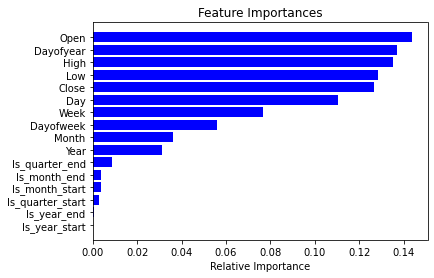

In [31]:
importances = model.feature_importances_
indices = np.argsort(importances)
# summarize feature importance
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [32]:
X_train.columns


Index(['Open', 'High', 'Low', 'Close', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'],
      dtype='object')

In [156]:
Y_test_preds[Y_test_preds > 0.5] = 1
Y_test_preds[Y_test_preds <= 0.5] = 0

In [157]:
Y_test_preds = pd.DataFrame(Y_test_preds)

In [158]:
Y_test_preds.shape

(1200, 1)

In [159]:
Y_test_preds.index = test.index

In [160]:
Y_test_preds.head()

,0
Date,
2012-01-19,0.0
2012-01-20,0.0
2012-01-23,0.0
2012-01-24,0.0
2012-01-25,0.0


In [161]:
Y_test_preds = Y_test_preds.iloc[5::6, :]

In [162]:
Y_test_preds.shape

(200, 1)

In [163]:
Y_test_preds.head()

,0
Date,
2012-01-26,0.0
2012-02-09,1.0
2012-02-24,0.0
2012-03-09,1.0
2012-03-23,0.0


In [164]:
Y_test_preds = Y_test_preds.astype(int)

In [165]:
Y_test_preds.to_csv('/Users/Kapil/Desktop/Y_test.csv')
